In [1]:
%matplotlib inline

from glob              import glob
from matplotlib        import pyplot as plt
from matplotlib.ticker import NullFormatter
from re                import findall

/Users/pepijn/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/Users/pepijn/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def read_bleu_pplx(patn,bleu_epochs,pplx_epochs):
    data = {}
    for output_path in glob(patn):
        with open(output_path, 'r') as output_file:
            output_contents = output_file.read()
            bleu_scores = map(float,findall(r'BLEU: (\d+\.\d+)', output_contents))
            bleu_scores = list(zip(bleu_epochs, bleu_scores))
            pplx_scores = map(float,findall(r'dev perplexity \| (\d+\.\d+)', output_contents))
            pplx_scores = list(zip(pplx_epochs, pplx_scores))
            data[output_path] = {'bleu': bleu_scores, 'pplx': pplx_scores}
    return data

In [3]:
def plot_bleu_pplx(data,name,words_in_dev,baseline=None):
    
    plt.figure(1, figsize=(8,8))
    
    bleu = plt.axes([0.0, 0.52, 0.8, 0.49])
    pplx = plt.axes([0.0, 0.0 , 0.8, 0.49])

    for key, val in data.items():
        epoch, bleu_score = zip(*val['bleu'])
        epoch = [e + 1 for e in epoch]
        bleu.plot(epoch, bleu_score, label=key)
        epoch, pplx_score = zip(*val['pplx'])
        epoch = [e + 1 for e in epoch]
        pplx.plot(epoch, pplx_score, label=key)

    def keep_lim(ax, func):
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        func(ax)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    
    if baseline:
        keep_lim(bleu, lambda ax: ax.scatter([baseline['epoch']], [baseline['bleu']], label='baseline'))
        keep_lim(pplx, lambda ax: ax.scatter([baseline['epoch']], [baseline['pplx']], label='baseline'))
        name['baseline'] = 'baseline'

    nullfmt = NullFormatter()
    bleu.xaxis.set_major_formatter(nullfmt)
    bleu.set_ylabel('BLEU')
    pplx.set_ylabel('Perplexity ({} words)'.format(words_in_dev))
    pplx.set_xlabel('# Epochs')

    handles, labels = bleu.get_legend_handles_labels()
    handles, labels = zip(*map(lambda t: (t[0], name[t[1]]),sorted(zip(handles, labels), key=lambda t: t[1])))
    bleu.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0.)

    plt.show()

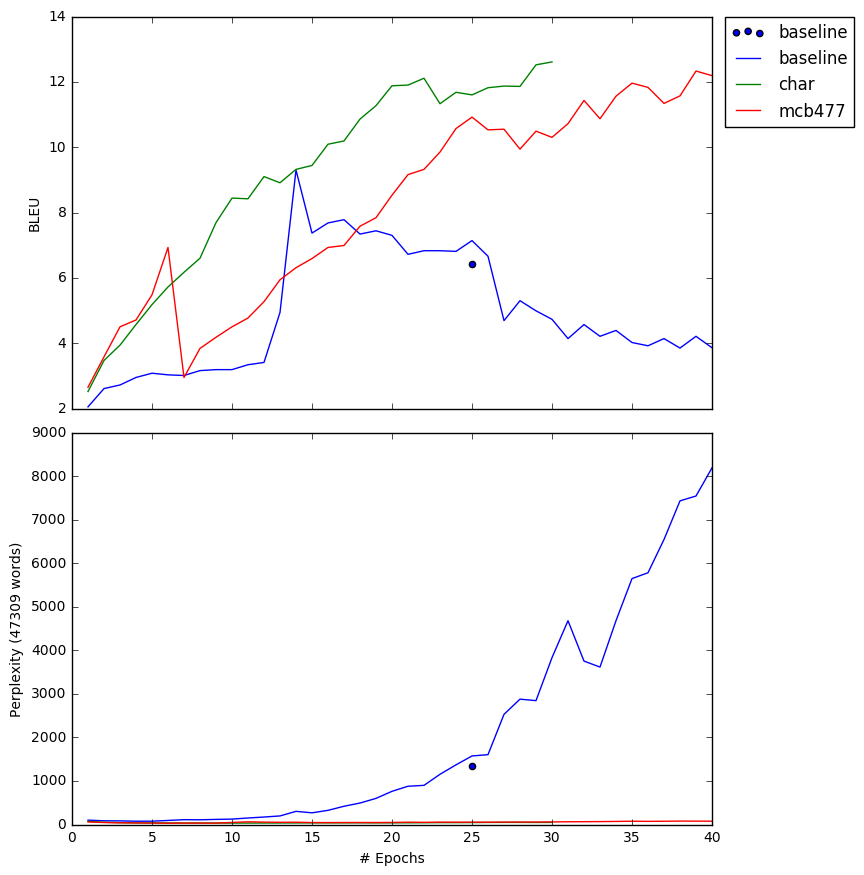

In [6]:
BLEU_EPOCHS = range(40)
PPLX_EPOCHS = range(40)
IN_BASE0 = {
    'bleu': 6.43,
    'pplx': 1341.369321,
    'epoch': 25
}
IN_WORDS_IN_DEV = 47309

IN_NAME = {
    'in_en_model_50000/seq2seq_50000sen_3-3layers_200units_base1_SOFT_ATTN.scores': 'baseline',
    'in_en_model_halfjack_50000/seq2seq_50000sen_3-3layers_200units_halfjack0_SOFT_ATTN.scores': 'char',
    'in_en_model_mcb477_50000/seq2seq_50000sen_3-3layers_200units_mcb477_SOFT_ATTN.scores': 'mcb477',
}

plot_bleu_pplx(read_bleu_pplx('in_en_model*50000/*.scores',
                             bleu_epochs=BLEU_EPOCHS,
                             pplx_epochs=PPLX_EPOCHS),
               name=IN_NAME, 
               words_in_dev=IN_WORDS_IN_DEV, 
               baseline=IN_BASE0)